# Lab Six: Convolutional Network Architectures

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Metric](#metric)<br>
  2.2 [Test-Train Split](#split)<br>
 3. [Modeling](#modeling)<br>
  3.1 [CNN](#cnn)<br>
  3.2 [Different Architectures](#architectures)<br>
  3.3 [Visualize Final Results](#visualize)<br>
  3.4 [Compare the Performance](#compare)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analyses](#additional_analysis)<br>
  4.2 [Transfer Learning](#Transfer_Learning)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>

## Data Selection

> Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

For this project we chose to use a [random sample of NIH Chest X-Ray Dataset](https://www.kaggle.com/nih-chest-xrays/sample/home). This dataset contains 5606 images that have been preprocessed to be a uniform size of $1024 \times 1024$ and also includes a csv containing the labels associated with the x-ray images. This dataset includes X Ray images of patients with 14 different diseases.

<a id="preparation"></a>

## Preparation

Before we define the metric and decide on a test-train split, we need to make sure all of the X-Ray images are the same format. The images are all the same size, but we will need to make sure all of them are black and white as well as flipping some of the images along the vertical axis to account for the different persepctives used (patient laying on back or front). While we are doing this we will also resize the images to a smaller size to make our testing run quicker. If we use left-right flipping as a part of our data expansion, the initial flipping will be unnecessary. However, we wanted to start from a common initial point to (hopefully) get a better of idea how the individual variables affect our model's performance.

We have also taken the 2D Fourier transformation of the images and saved the transformations as numpy arrays as well as an image of the transforms. We may augment our model with the transformed space in order to see if there is any increase in performance with the additional "momentum" space information.

Finally, we will also need to do some work on the target to make it into a binary classification problem. Initially we will only try to classify the instances based on whether the patient had pnemonia or not. In the future we can also look at a binary classification of whether the patient had any disease or not. Finally, we can also try to a multi-classification model to predict each of the diseases individually. However, given that we only have ~5,000 images (before expansion), we do not think this model would perform very well.

In [1]:
import pandas as pd

# first read in the dataframe that gives us the perspective
df = pd.read_csv('sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [50]:
# resize and save the images
import os
from PIL import Image
import time
from IPython.display import display, clear_output

size = 1024
base = os.getcwd()
full = os.path.join(base,'sample/images/')
t_start = time.time()

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}

i=0
errors = 0
for (dirpath, dirnames, filenames) in os.walk(full):
    for file in filenames:
        # get the info from the df
        # possibly a more efficient way to do this, but this works
        row = df[df['Image Index']==str(file)]
        if row['View Position'].values[0] == 'PA':
            # flip the PA
            img = Image.open(os.path.join(full, file)).convert('L').transpose(Image.FLIP_LEFT_RIGHT)
        elif row['View Position'].values[0] == 'AP':
            # keep AP
            img = Image.open(os.path.join(full, file)).convert('L')
        else:
            # in case there is an error
            img = Image.open(os.path.join(full, file)).convert('L')
            error += 1
            with open('sample/proj.dat', 'a+') as f:
                f.write('Could not find image {} in the df\n'.format(file))
                f.write(str(row['View Position']=='PA'))
        o_size = img.size
        s = size, size
        img.thumbnail(s)
        img.save(os.path.join(base, 'sample', size_dict[size], file))
        clear_output()
        display('finished #{}: {}: Original Dims ({} {}) : Finial Dims ({} {}): time {:.2f} seconds'.format(i, file, o_size[0], o_size[1], img.size[0], img.size[1], time.time()-t_start))
        i+=1
print('{} files missed, check proj.dat file'.format(errors))

'finished #5605: 00030797_000.png: Original Dims (1024 1024) : Finial Dims (1024 1024): time 1488.72 seconds'

0 files missed, check proj.dat file


In [20]:
# now the Fourier transforms in case we use that information.
import numpy as np
import os
from PIL import Image
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

base = os.getcwd()
print(base)
t_start = time.time()

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}

#sizes = [64, 128, 256, 512, 1024]
sizes = [64]
for size in sizes:
  
    read_dir = os.path.join(base, 'sample', size_dict[size])
    write_dir = read_dir+'_fft'
    
    i = 0
    for (dirpath, dirnames, filenames) in os.walk(read_dir):
        for file in filenames:
            # read image
            img = Image.open(os.path.join(read_dir, file))
            fft = np.fft.fft2(img)
            fft_abs = np.abs(fft)
            f, _ = os.path.splitext(file)
            np.save(write_dir+'/'+f+'.fft', fft)
        
            #fig, ax = plt.subplots(figsize=(5,5))
            #im = ax.imshow(fft_abs, cmap='hot', norm=LogNorm(vmin=0.1))
            #ax.set(xticks=[], yticks=[], title=file)
            #cb = fig.colorbar(im)
            #fig.savefig(os.path.join(write_dir, file))
            #plt.close(fig)
        
            clear_output()
            display('finished #{}: {}: size {}: time {:.2f} seconds'.format(i, file, size, time.time()-t_start))
            i+=1

'finished #5605: 00030797_000.png: size 64: time 48.12 seconds'

In [2]:
import numpy as np

# check if the frame contains 'No Finding' True if the patient was sick, False if not
y_sick = ~df['Finding Labels'].str.contains('No Finding')

# now check for pneumonia, True if patient has pneumonia, False else
y_pneumonia = df['Finding Labels'].str.contains('Pneumonia')


# now make target for all diseases

disease_list = ['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly', 'Pleural_Thickening',
                'Consolidation', 'Pneumothorax', 'Mass', 'Nodule', 'Atelectasis', 'Effusion', 'Infiltration', 'No Finding']

def disease_to_list(string, full_results = disease_list):
    '''Function to generate a list of the different diseases each patient has
    Inputs
    string: the string containing the diseases, ie df['Finding Labels']
    full_results: the list of all possible diseases used for the indices in the resulting list
    Returns
    list: a list with False if the patient didn't have the disease and True if the patient did. Indices based on full_results
    '''
    diseases = string.split('|')
    result = [False]*len(full_results)
    
    for d in diseases:
        result[full_results.index(d)] = True
    return result

y_all_l = df['Finding Labels'].apply(disease_to_list) # series version of .apply(). This returns a pd.series of lists
y_all = pd.DataFrame(y_all_l.tolist(), columns = disease_list) # convert to a pd.dataframe

# now check that the totals match kaggle https://www.kaggle.com/nih-chest-xrays/sample
y_all.sum(axis=0)

Hernia                  13
Pneumonia               62
Fibrosis                84
Edema                  118
Emphysema              127
Cardiomegaly           141
Pleural_Thickening     176
Consolidation          226
Pneumothorax           271
Mass                   284
Nodule                 313
Atelectasis            508
Effusion               644
Infiltration           967
No Finding            3044
dtype: int64

<a id="Metric"></a>

### Metric

> __[15 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For this project we chose to use two metrics. 

- First, the F1 score. This metric allows us to account for false positives as well as false negatives, which improves over a simple accuracy. Although a more in-depth metric, such as a custom cost matrix, may allow for finer tuning of the performace of our model, it removes the ability for us to compare our model with others.  

- Second, Recall. This metric emphesizes captureing all of the X Rays with a disease without much regard for false positives. In this situation, this is okay because the false positives will likley just have additional screenings or tests, while a false negative could have serioius health consequences for the patient.

<a id="split"></a>

### Test-Train Split

> __[15 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

For this project we will use 70% of the data for training, 10% for validation, and the remaining 20% for testing. Since we also have a class imbalance, we will use stratification at each splitting to ensure that all of the labels are represented appropriately in the sub-samples. Since Keras automatically manages the separation of the validation and training, we will manually split the 20% for testing from the remaining 80%. Furthermore, we will only split the pneumonia target for now.

In [3]:
from sklearn.model_selection import train_test_split

dat_train, dat_test, y_train, y_test = train_test_split(df, y_sick, test_size=0.2, random_state=42, stratify=y_pneumonia)

<a id="Modeling"></a>

## Modeling

<a id="cnn"></a>

### CNN

> __[15 points]__ Create a convolutional neural network to use on your data using Keras. Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 

The expansion techniques we use are

- Rotation: We will allow for our images to be rotated up to 5 degrees in either direction.
- Up-Down flip: We will allow for horizantal flipping.
- Shifts: We will allow for horizontal and vertical shifts

In [4]:
# the datagen 
# from class: https://github.com/eclarson/MachineLearningNotebooks/blob/master/12.%20More%20Advanced%20CNN%20Techniques.ipynb
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)


Using TensorFlow backend.


working on train 4483, 00029666_001.png, 73.95


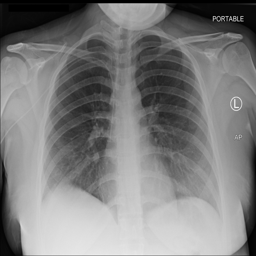

In [5]:
%matplotlib inline
from PIL import Image
import time
import os
from IPython.display import display, clear_output
# load the images. this is going to take a fair amount of memory...


size = 256

size_dict = {64:  '64x64',
             128: '128x128',
             256: '256x256',
             512: '512x512',
             1024:'1024x1024'}
path = os.path.join(os.getcwd(), 'sample', size_dict[size])

X_test = np.empty([len(dat_test), size, size, 1], dtype=np.float32) # preallocate
X_train = np.empty([len(dat_train), size, size, 1], dtype=np.float32) # num_images, img_width, img_height, num_channels

X_test[:,:,:,0]=1
X_train[:,:,:,0]=1

index = 0
t_start = time.time()
for name in dat_test['Image Index']:
    clear_output()
    print('working on test {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    display(img)
    X_test[index,:,:,0] = np.array(img)/255.0-0.5
    index+=1

index = 0
t_start = time.time()
for name in dat_train['Image Index']:
    clear_output()
    print('working on train {}, {}, {:.2f}'.format(index, name, time.time()-t_start))
    img = Image.open(os.path.join(path, name))
    display(img)
    X_train[index,:,:,0] = np.array(img)/255.5-0.5
    index+=1

In [19]:
# Convolutional Neural Network
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

visible = Input(shape=(size,size,1))

conv1 = Conv2D(32, kernel_size=3, activation='relu')(visible)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(16, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(16, kernel_size=3, activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1, kernel_size=3, activation='relu')(pool4)
pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

flat = Flatten()(pool5)
hidden1 = Dense(20, activation='relu')(flat)
hidden2 = Dense(10, activation='relu')(hidden1)
output = Dense(1, activation='sigmoid')(hidden2)

model = Model(inputs=visible, outputs=output)
# summarize layers
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 16)        0         
__________

In [20]:
from keras.utils import to_categorical
import tensorflow as tf
#print(y_train.shape)
#print(y_test.shape)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=int(len(X_train)/32), # how many generators to go through per epoch
                        epochs=5, verbose=1,
                        validation_data=(X_test,y_test)
                        )

(4484,)
(1122,)
Epoch 1/5
140/140 [==============================] - 20s 142ms/step - loss: 0.6763 - acc: 0.5788 - val_loss: 0.6668 - val_acc: 0.5989
Epoch 2/5
140/140 [==============================] - 18s 130ms/step - loss: 0.6693 - acc: 0.6002 - val_loss: 0.6605 - val_acc: 0.6016
Epoch 3/5
140/140 [==============================] - 18s 131ms/step - loss: 0.6645 - acc: 0.5980 - val_loss: 0.6506 - val_acc: 0.6248
Epoch 4/5
140/140 [==============================] - 18s 131ms/step - loss: 0.6623 - acc: 0.6125 - val_loss: 0.6483 - val_acc: 0.6257
Epoch 5/5
140/140 [==============================] - 18s 131ms/step - loss: 0.6639 - acc: 0.6127 - val_loss: 0.6541 - val_acc: 0.6087


In [13]:
import gc
import keras.backend as K

model = None
gc.collect()
K.clear_session()

<a id="architectures"></a>

### Different Architectures

> __[20 points]__ Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

<a id="visualize"></a>

### Visualize Final Results

> __[15 points]__ Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 

<a id="compare"></a>

### Compare the Perfomace

> __[10 points]__ Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

<a id="exceptional"></a>

## Exceptional Work

<a id="additional_analyses"></a>

### Additional Analyses

> You have free reigh to provide additional analyses.

In addition to simply predicting whether or not a patient has one of the conditions, it may also be useful to know which sections of the X Ray were most indicative of the condition. To extract this information we will add heatmaps to the images using class activation mappings (CAMs).

In [ ]:
import keras.backend as K

get_layer = K.function(
    [model.layers[0].input, K.learning_phase()],
    [model.layers[LAYER_DESIRED].output])
layer_output = get_layer([x_test, 0])[0]

<a id="Transfer_Learning"></a>

### Transfer Learning

> One idea (__required for 7000 level students__): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training from scratch in terms of classification performance.

<a id="thoughts"></a>

## Final Thoughts